## Στοιχεία Ομάδας
* Γεώργιος - Κωνσταντίνος Ζαχαρόπουλος AM: 1115201900061
* Ευστράτιος-Πασχάλης Κακαλής ΑΜ: 1115201900068

## Imports

In [ ]:
import re
import nltk
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from google.colab.data_table import DataTable

In [ ]:
#sets the output of dataframe matrix to 32 columns
# pd.set_option('display.max_columns', 32)
# DataTable.max_columns = 32

### Extra functions

In [ ]:
def column_to_numeric(df, col_name):
  df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
  df = df.dropna(subset=[col_name])
  return df[col_name]

## Ζητούμενα

In [ ]:
#Reading the csv file
df = pd.read_csv('/content/books_1.Best_Books_Ever.csv', sep=',')

#Finding the empty cells (NaN) in the dataframe if they exist
rows, _ = np.where(pd.isnull(df[['bookId', 'description', 'publishDate', 'ratingsByStars', 'genres', 'author', 'title', 'publisher', 'language']]))

#Remove the specified rows
if rows.any():
  df = df.drop(labels=rows, axis=0)

print("Dataframe shape after Nan cleaning: " + str(df.shape))

Dataframe shape after Nan cleaning: (44995, 25)


### Προεπεξεργασία

In [ ]:
#creating 5 new columns about ratingStars
df[['ratingStar5','ratingStar4','ratingStar3','ratingStar2','ratingStar1']] = df['ratingsByStars'].str.split(",", expand = True)

#extraction the digits out of the rankings (eg. "[1293," -> 1293)
for col in ['ratingStar5','ratingStar4','ratingStar3','ratingStar2','ratingStar1']:
  df[col] = df[col].str.extract('(\d+)')

#creating 1 new column about the gernes of the book
df['genreSingle'] = df['genres'].str.split(",", expand = True)[0]
df['genreSingle'] = df['genreSingle'].str.extract('(\w+)')

#There are no books without a genre###

#creatin 1 new column for the publish year
#trasnform the %d/%m/%y dates (eg. 05/12/86) into %y (eg. 86)
df['publishYear'] = df['publishDate'].apply(lambda x: x.split('/')[-1])
#trasnform the month day year dates (eg. September 13th 2016) into year (eg. 2016)
df['publishYear'] = df['publishYear'].apply(lambda x: x.split(' ')[-1])
df['publishYear'] = column_to_numeric(df, 'publishYear')

#add 20 or 19 infront of some dates for consistency.
#Look for 4 characters because of this format: xx.0 some values are x.0 so account for that too.
df['publishYear'] = df['publishYear'].apply(lambda x: f'19{x}' if len(str(x)) == 4 and x > 23 else x)
df['publishYear'] = df['publishYear'].apply(lambda x: f'20{x}' if len(str(x)) == 4 and x < 23 else x)

df['publishYear'] = df['publishYear'].apply(lambda x: f'190{x}' if len(str(x)) == 3 and x > 23 else x)
df['publishYear'] = df['publishYear'].apply(lambda x: f'200{x}' if len(str(x)) == 3 and x < 23 else x)

print("Dataframe shape after creating the asked columns " + str(df.shape))

Dataframe shape after creating the asked columns (44995, 32)


### Ερωτήματα για μελέτη των δεδομένων 

#### 1

<Axes: >

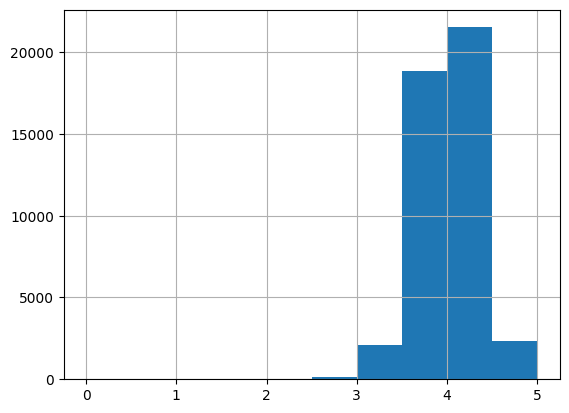

In [ ]:
df['rating'].hist()

#### 2

In [ ]:
df['pages'] = column_to_numeric(df, 'pages')

df.sort_values(by=['pages'], ascending=False, inplace=True)
df[['title', 'pages']].head(10)

,title,pages
11490,The Story of Civilization,14777.0
22960,The Complete Wheel of Time,11095.0
8374,The Complete Malazan Book of the Fallen,8258.0
5098,Animorphs,8245.0
20098,Homestuck,8124.0
3148,Worm,6680.0
23326,سه تفنگدار: ١٠ جلدی,6600.0
4692,The Complete Aubrey/Maturin Novels (5 Volumes),6576.0
14269,البداية والنهاية,6088.0
1679,A Song of Ice and Fire,5216.0


#### 3

In [ ]:
df['ratingStar5'] = column_to_numeric(df, 'ratingStar5')

#drop books with fewer than 10.000 5 star reviews
temp_df = df.drop(df[df.ratingStar5 < 10000].index)

temp_df.sort_values(by=['ratingStar5'], ascending=False, inplace=True)
temp_df[['title', 'ratingStar5']].head(10)

,title,ratingStar5
32,Harry Potter and the Sorcerer's Stone,4578137.0
0,The Hunger Games,3444695.0
2,To Kill a Mockingbird,2363896.0
71,Harry Potter and the Deathly Hallows,2038930.0
93,Harry Potter and the Prisoner of Azkaban,1892635.0
10,The Fault in Our Stars,1784471.0
4,Twilight,1751460.0
103,Harry Potter and the Goblet of Fire,1729403.0
105,Harry Potter and the Half-Blood Prince,1646703.0
3,Pride and Prejudice,1617567.0


#### 5

In [ ]:
authorsCount = df['author'].value_counts()
authorsCount.head(10)

Nora Roberts (Goodreads Author)       86
Agatha Christie                       70
Stephen King (Goodreads Author)       64
Erin Hunter                           49
Karen Kingsbury (Goodreads Author)    48
Meg Cabot (Goodreads Author)          48
Terry Pratchett                       47
Enid Blyton                           43
Mercedes Lackey                       43
Carolyn Keene                         42
Name: author, dtype: int64

#### 8

In [ ]:
authorsCount = df['publisher'].value_counts()
authorsCount.head(10)

Vintage             560
HarperCollins       505
Penguin Books       412
Ballantine Books    385
Bantam              347
Pocket Books        307
Avon                305
Del Rey             282
Berkley             278
Tor Books           276
Name: publisher, dtype: int64

### Υλοποίηση Recommendation system

In [ ]:
temp_df = df[['bookId', 'description', 'language', 'title']].copy()
temp_df.drop(temp_df[temp_df.language != 'English'].index, inplace=True)
temp_df = temp_df.drop_duplicates(subset=['bookId'], keep='first')

print("Dataframe shape after droping non-english books and keeping the only unique ids " + str(temp_df.shape))

Dataframe shape after droping non-english books and keeping the only unique ids (39736, 4)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2), max_features=500)
tfidf = tfidf_vectorizer.fit_transform(temp_df['description'])

In [ ]:
def get_100_similar(df, bookId):
  similar_books = {}

  book_row_index = df.loc[df['bookId'] == bookId].index
  other_books_index = -1

  print("For " + bookId + " with index " + str(book_row_index) + " searching the 100 most similar")
  for other_books in df.iterrows():
    other_books_index += 1

    #important to skip each own self
    if book_row_index == other_books_index:
      continue

    similarity = cosine_similarity(tfidf[book_row_index],tfidf[other_books_index])
    if similarity > 0.0 :
      similar_books[other_books[1]['bookId']] = float(similarity)

  similar_books = dict(sorted(similar_books.items(), key=lambda item: item[1], reverse=True))
  return list(similar_books.items())

def recommend(df, bookId, N, booklist):
  print("Recommending " + str(N) + " books for " + bookId)
  
  for book in booklist[:N]:

    row = df.loc[df['bookId'] == book[0]]
    description = row['description'].to_string()
    title = row['title'].to_string()
    score = str(book[1])

    print("---------------------------------------------")
    print("Recommended: " + title)
    print("Description: " + description)
    print("Score: " + score)


In [ ]:
#temp_df['bookId'][0] -> '2767052-the-hunger-games'
most_100_similar = get_100_similar(temp_df , '2767052-the-hunger-games')

For 2767052-the-hunger-games with index Int64Index([0], dtype='int64') searching the 100 most similar


In [ ]:
recommend(temp_df, '2767052-the-hunger-games', 5, most_100_similar)

Recommending 5 books for 2767052-the-hunger-games
---------------------------------------------
Recommended: 18754    The Age of Extremes: A History of the World, 1...
Description: 18754    Dividing the century into the Age of Catastrop...
Score: 0.8480153651844664
---------------------------------------------
Recommended: 15127    Mutant Message From Forever
Description: 15127    Susret s australskom domorodačkom civilizacijo...
Score: 0.7376408667337095
---------------------------------------------
Recommended: 36655    Anne of Green Gables: The Complete Collection
Description: 36655    Anne of Green Gables [Anne Shirley Series][Boo...
Score: 0.6653774721087078
---------------------------------------------
Recommended: 8014    Our Oriental Heritage
Description: 8014    This is the classic reference on world history...
Score: 0.6176395094166428
---------------------------------------------
Recommended: 34235    Dragon Age, Volume 1
Description: 34235    Helping set the stage for BioWa

### Υλοποίηση Κατηγοριοποίησης


In [ ]:
#First get top 10 most common genres from genreSingle column.
most_common_genres = df['genreSingle'].value_counts().head(10)
new_df = df[df['genreSingle'].isin(most_common_genres.index)]
#We only need bookId, description and genreSingle so drop the rest.
columns_to_keep = ['bookId', 'description', 'genreSingle']
df_filtered = new_df.drop(columns=[col for col in df.columns if col not in columns_to_keep])
df = df_filtered

print("Dataframe with books from the top 10 genres: " + str(df.shape))

Dataframe with books from the top 10 genres: (26272, 3)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-05-24 17:27:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-24 17:27:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-24 17:27:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

<ipython-input-19-c209e660ae6d>:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, w2v_output_file)


(400000, 300)

Data preprocessing on the dataframe column 'description'

In [ ]:
nltk.download('popular')
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def data_preprocessing(df):
  # remove html tags
  df['description'] = df['description'].apply(lambda s: re.sub('<.*?>', '', s))

  # remove special chars and numbers
  df['description'] = df['description'].str.replace("[^A-Za-z]+", ' ', regex=True)

  # tokenize
  df['description'] = df['description'].apply(word_tokenize)

  # remove stopwords
  df['description'] = df['description'].apply(lambda s: ([word.lower() for word in s if word not in (stopwords)]))

  # lemmatize
  df['description'] = df['description'].apply(lambda s: ([lemmatizer.lemmatize(word) for word in s]))

  return df

df = data_preprocessing(df)


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [ ]:
#Also encode the genreSingle column so that it's used easily for labels.
#Create an instance of LabelEncoder
label_encoder = LabelEncoder()

#Fit and transform the 'genre' column
encoded_column = label_encoder.fit_transform(df['genreSingle'])

In [ ]:
word2vec = KeyedVectors.load_word2vec_format(w2v_output_file, datatype=float, binary=False)

model_dict = {}

#we make the word2vec a dict to have fast searches
for word in word2vec.index_to_key:
  model_dict[word] = word2vec.get_vector(word)

In [ ]:
tensors = []
genres = []

def descriptions_to_tensors(df):
  #iterate through all of the descriptions and results
  for (desc, genre) in zip(df['description'], encoded_column):
    #for each description keep in a dict only the distinct words
    desc_dict = {}
    for word in desc:
      if word not in desc_dict:
        desc_dict[word] = len(desc_dict)    
    
    #for each distict word get the vector
    tensor = np.zeros(300)
    count = 0

    for word in desc_dict:
        if word in model_dict:
          #add up all vectors
          tensor += model_dict[word]
          count += 1
    
    #devide final vector by the sum of words
    if count != 0:
      tensor /= count

    #add tensor to the list
    tensors.append(torch.tensor(tensor, dtype=torch.float))
    genres.append(torch.tensor(genre, dtype=torch.float))

  #stack all the tensors
  x = torch.stack(tensors)
  y = torch.stack(genres)

  return x, y

tensors, genres = descriptions_to_tensors(df)
print (tensors, genres)

tensor([[-0.0391, -0.0618, -0.0658,  ..., -0.0076, -0.1582,  0.0462],
        [ 0.0861,  0.1157,  0.0348,  ...,  0.0384, -0.1374,  0.0401],
        [-0.0625, -0.0232,  0.0722,  ...,  0.0272, -0.0290,  0.0090],
        ...,
        [-0.0512, -0.1006, -0.0483,  ..., -0.0613,  0.0457,  0.1316],
        [ 0.0955,  0.1349,  0.0733,  ..., -0.0247, -0.0685,  0.0608],
        [-0.0811,  0.0240, -0.0156,  ...,  0.0606, -0.2026,  0.0905]]) tensor([4., 1., 1.,  ..., 6., 2., 2.])


Use Pickle to save wanted information so we can easily load it later.

In [ ]:
with open('variables.pkl', 'wb') as file:
    pickle.dump(tensors, file)
    pickle.dump(genres, file)

Load data without running the code again.

In [ ]:
with open('variables.pkl', 'rb') as file:
    loaded_tensors = pickle.load(file)
    loaded_genres = pickle.load(file)

print(loaded_tensors, loaded_genres)
tensors = loaded_tensors
genres = loaded_genres

tensor([[-0.0391, -0.0618, -0.0658,  ..., -0.0076, -0.1582,  0.0462],
        [ 0.0861,  0.1157,  0.0348,  ...,  0.0384, -0.1374,  0.0401],
        [-0.0625, -0.0232,  0.0722,  ...,  0.0272, -0.0290,  0.0090],
        ...,
        [-0.0512, -0.1006, -0.0483,  ..., -0.0613,  0.0457,  0.1316],
        [ 0.0955,  0.1349,  0.0733,  ..., -0.0247, -0.0685,  0.0608],
        [-0.0811,  0.0240, -0.0156,  ...,  0.0606, -0.2026,  0.0905]]) tensor([4., 1., 1.,  ..., 6., 2., 2.])


Split the tensors to train and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tensors, genres, train_size=0.8, random_state=42)

* Naive Bayes Classification

In [ ]:
# Initialize and train the Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(x_train, y_train)

# Predict the labels for the test data
y_pred = nb_classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

Accuracy: 0.3170313986679353


* Support Vector Machines

In [ ]:
#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1]
}

svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(x_train, y_train)

#Retrieve the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best hyperparameters: " + str(best_params))
print("Best score: " + str(best_score))

Best hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best score: 0.6342483269958276


After the SVM tunning we know that the best combination of hyperparameters is:  **C:1, gamma:1, kernel:rbf**

* Random Forests

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train, y_train)

y_pred = rf_classifier.predict(x_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.5115128449096099


Use the 10-fold cross validation for each of the models we just trained:

In [ ]:
def TenFoldValidation (x, y, model):
  #Perform 10-fold cross-validation
  scores = cross_val_score(model, x, y, cv=10)
  #Calculate metrics.
  predicted_labels = cross_val_predict(model, x, y, cv=10)

  # Calculate evaluation metrics for each fold
  precision = precision_score(y, predicted_labels, average=None)
  recall = recall_score(y, predicted_labels, average=None)
  f_measure = f1_score(y, predicted_labels, average=None)
  accuracy = accuracy_score(y, predicted_labels)

  print("---------------------------------------------------------------------")

  # Print the metrics for each fold
  for fold_idx, fold_score, fold_precision, fold_recall, fold_f_measure in zip(range(10), scores, precision, recall, f_measure):
      print(f"Fold {fold_idx+1}:")
      print("Precision:", fold_precision)
      print("Recall:", fold_recall)
      print("F-Measure:", fold_f_measure)
      print("Accuracy:", fold_score)
      print("--------------------------")

  # Calculate and print the average metrics
  avg_precision = precision_score(y, predicted_labels, average='weighted')
  avg_recall = recall_score(y, predicted_labels, average='weighted')
  avg_f_measure = f1_score(y, predicted_labels, average='weighted')
  avg_accuracy = scores.mean()

  print("Average Precision: ", avg_precision)
  print("Average Recall: ", avg_recall)
  print("Average F-Measure: ", avg_f_measure)
  print("Average Accuracy: ", avg_accuracy)

  # Plot the per-fold accuracy
  plt.figure(figsize=(8, 6))
  fold_indices = np.arange(1, 11)
  plt.bar(fold_indices, scores, color='blue', alpha=0.7)
  plt.xlabel('Fold')
  plt.ylabel('Accuracy')
  plt.title('Per-Fold Accuracy')
  plt.xticks(fold_indices)
  plt.ylim([0, 1])
  plt.show()

---------------------------------------------------------------------
Fold 1:
Precision: 0.10798611111111112
Recall: 0.29590865842055186
F-Measure: 0.1582294581531417
Accuracy: 0.3211567732115677
--------------------------
Fold 2:
Precision: 0.7797979797979798
Recall: 0.30744723217841496
F-Measure: 0.4410168523279063
Accuracy: 0.3230593607305936
--------------------------
Fold 3:
Precision: 0.4436936936936937
Recall: 0.03473814142126609
F-Measure: 0.06443172526573998
Accuracy: 0.31480776551199086
--------------------------
Fold 4:
Precision: 0.35452961672473865
Recall: 0.33553173948887055
F-Measure: 0.34476916560779325
Accuracy: 0.3231823372668443
--------------------------
Fold 5:
Precision: 0.3356997971602434
Recall: 0.354389721627409
F-Measure: 0.3447916666666667
Accuracy: 0.32660829843928435
--------------------------
Fold 6:
Precision: 0.30579881656804736
Recall: 0.7025557368134856
F-Measure: 0.4261213720316622
Accuracy: 0.32584697373429766
--------------------------
Fold 7:
Preci

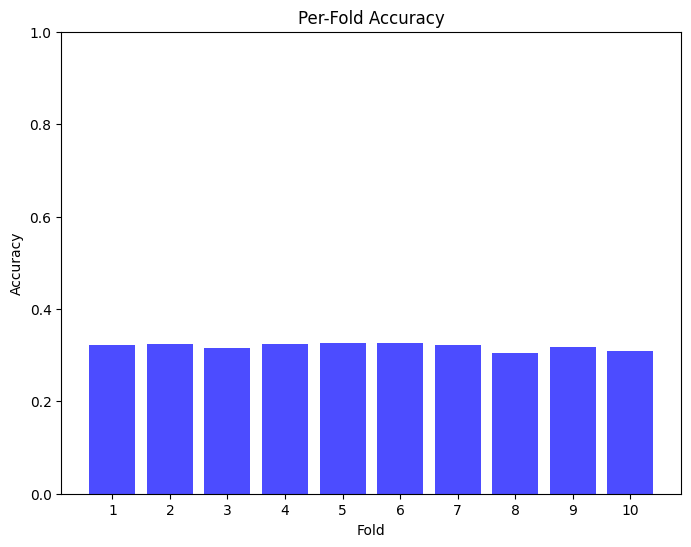

---------------------------------------------------------------------
Fold 1:
Precision: 0.6820276497695853
Recall: 0.28163653663177923
F-Measure: 0.39865319865319865
Accuracy: 0.6472602739726028
--------------------------
Fold 2:
Precision: 0.7377140729709606
Recall: 0.7891278375149343
F-Measure: 0.7625553203771408
Accuracy: 0.6533485540334856
--------------------------
Fold 3:
Precision: 0.5211813120309853
Recall: 0.7593017104567096
F-Measure: 0.61810091150506
Accuracy: 0.6318995051389418
--------------------------
Fold 4:
Precision: 0.6328920570264766
Recall: 0.5123660346248969
F-Measure: 0.5662870159453303
Accuracy: 0.6326608298439285
--------------------------
Fold 5:
Precision: 0.7377567140600316
Recall: 0.5
F-Measure: 0.5960433950223357
Accuracy: 0.6486486486486487
--------------------------
Fold 6:
Precision: 0.7167056074766355
Recall: 0.66721044045677
F-Measure: 0.6910729372007886
Accuracy: 0.6429387133612485
--------------------------
Fold 7:
Precision: 0.7570247933884298
Rec

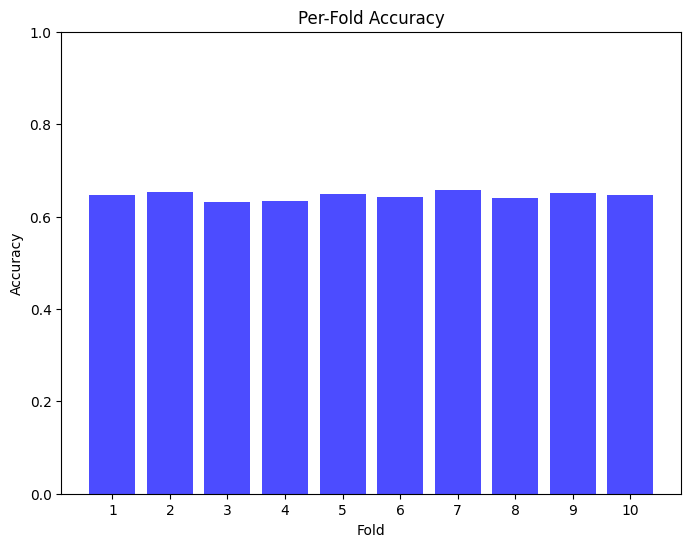

In [ ]:
#Combine the training and test sets because we need to split them in the 10-fold method.
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

#Run it for each model.
nb_classifier = GaussianNB()
TenFoldValidation(x, y, nb_classifier)
svm = SVC(kernel='rbf', C=1, gamma=1)
TenFoldValidation(x, y, svm)
rf_classifier = RandomForestClassifier()
TenFoldValidation(x, y, rf_classifier)

## Bonus

* First step is to get the covers of the books and save them into a folder on the drive.

In [ ]:
# Imports.
import os
import csv
import time
import cv2
import random
import numpy as np
import pandas as pd
import urllib.request
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#replace it with your path
DIR_PATH = "/content/gdrive/MyDrive/Colab_Notebooks/Data_Mining/Covers/"

In [ ]:
def get_books_cover(DIR_PATH, books, bookIds):
        """
        Retrieves books covers to a img/ directory
        Will work on existing books class attribute, so a GoodReads list should be scraped or a books list loaded
        (csv_to_books) before use.
        :return: None
        """
        img_dir = "img"
        check_folder = os.path.isdir(DIR_PATH + img_dir)

        # If folder doesn't exist, then create it.
        if not check_folder:
            os.makedirs(DIR_PATH + img_dir)
            print("Creating folder: ", img_dir)
        else:
            print(img_dir, "folder already exists, saving images to folder.")

        # Download covers
        for (book, bookId) in zip(books, bookIds):    
            if (book == None): 
              continue
            urllib.request.urlretrieve(book, DIR_PATH + "img/" + bookId  + ".jpg")
            # Set a respectful wait time
            time.sleep(2)

In [ ]:
file = DIR_PATH + "books_1.Best_Books_Ever.csv"

In [ ]:
finalbooks = pd.read_csv(file)

In [ ]:
images = finalbooks['coverImg']
Ids = finalbooks['bookId']

In [ ]:
#finally get the images
get_books_cover(DIR_PATH, images, Ids)

* Now split the images into a train and test set.

In [ ]:
#First we need to import the images from our files into python context.
# Get a list of all image file names in the folder
image_files = [file for file in os.listdir(DIR_PATH + "img") if file.endswith('.jpg')]

#Now using sklearn's test_split we will split the images into two sets, a train set 95% and a test set 5%.
train_filenames, test_filenames = train_test_split(image_files, train_size=0.95, random_state=42)

# Create the paths for train and test sets
trainS = [os.path.join(DIR_PATH + "img", file) for file in train_filenames]
testS = [os.path.join(DIR_PATH + "img", file) for file in test_filenames]

print("Count of train images: " + str(len(trainS)) + " ,count of test images: " + str(len(testS)))

Count of train images: 248 ,count of test images: 14


* Calculate histogram for each image.

In [ ]:
#Returns a dataframe with three histograms for each color.
def CalculateHistogram(image_path):
  img = cv2.imread(image_path)
  # define colors to plot the histograms
  colors = ('b','g','r')
  
  # compute and plot the image histograms
  image_hists =[]
  for i,color in enumerate(colors):
    hist = cv2.calcHist([img],[i],None,[32],[0,256])
    image_hists.append(hist.flatten())

  unified_vector = np.concatenate(image_hists, axis=0)
  return unified_vector

In [ ]:
# Calculate histogram for each image, histogram_dfs is a list of dataframes each containing  three  columns, each for a color histogram.
cols = ['BookId', 'Histogram']
histogram_df = pd.DataFrame(columns=cols)

for image_path in trainS:
  histogram = CalculateHistogram(image_path)

  # Define the new row to be added
  new_row = {'BookId': image_path, 'Histogram': histogram}
  # Use the loc method to add the new row to the DataFrame
  histogram_df.loc[len(histogram_df)] = new_row

* Pick an image from the test set and calculate it's histogram.

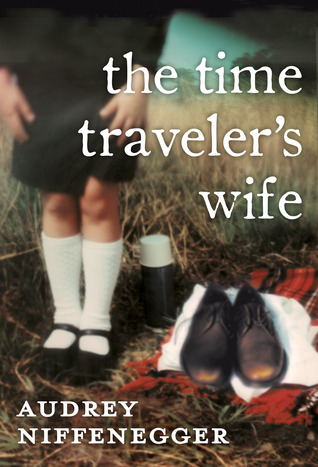

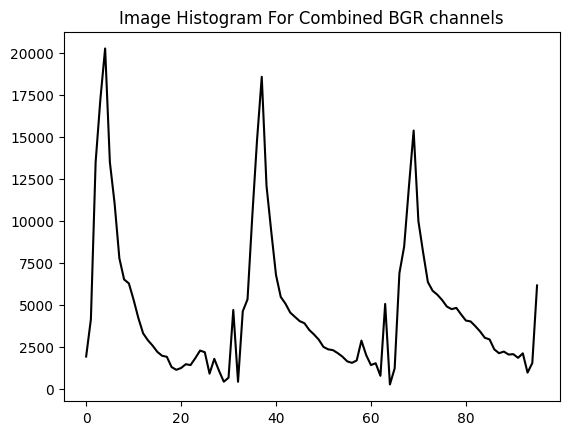

In [ ]:
def ShowImage(histogram, img):
  cv2_imshow(img)
  plt.plot(histogram, color='black')
  plt.title('Image Histogram For Combined BGR channels')
  plt.show()

test_image_path = testS[random.randint(0, len(testS) - 1)]
test_image = cv2.imread(test_image_path)
im_hist = CalculateHistogram(test_image_path)
ShowImage(im_hist, test_image)

* Now the 4 most similar images by:
  * Euclidean Distance.
  * Cosine Similarity.



In [ ]:
# Return the closest 4 vectors by euclidean distance.
def euclidean_nearest(target_vector, vectors_list):
    distances = []

    for vector in vectors_list:
        distance = np.linalg.norm(target_vector - vector)
        distances.append(distance)

    distances = np.array(distances)
    closest_indices = distances.argsort()[:4]
    closest_vectors = [vectors_list[i] for i in closest_indices]

    return closest_vectors

The closest 4 images to the one above are:


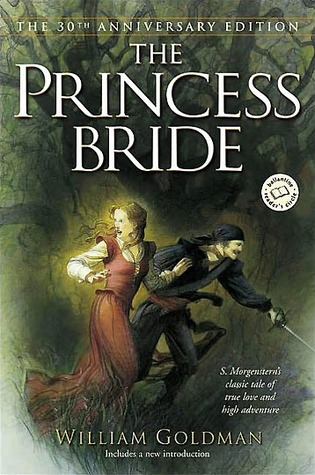

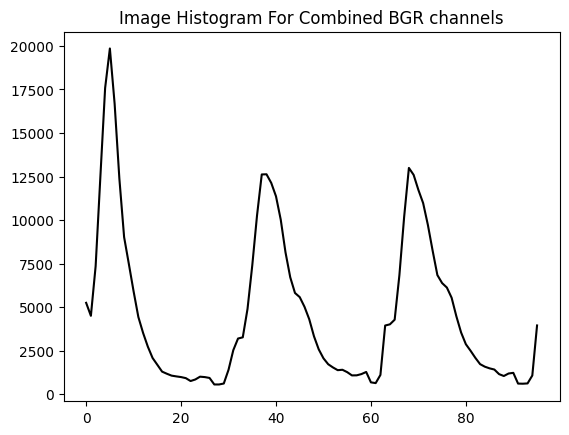

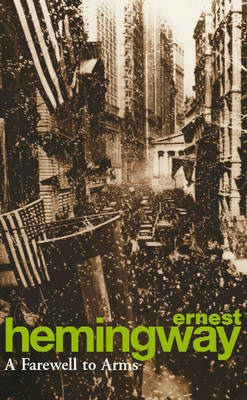

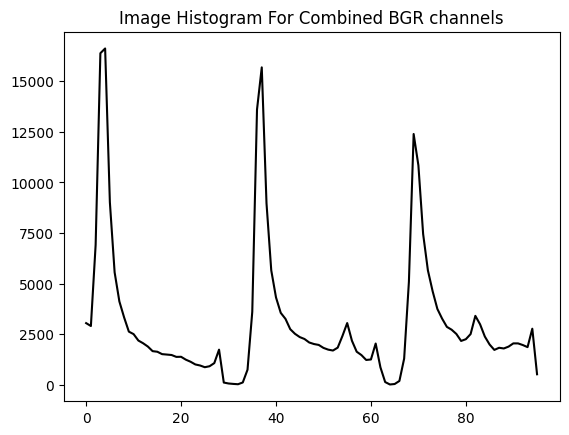

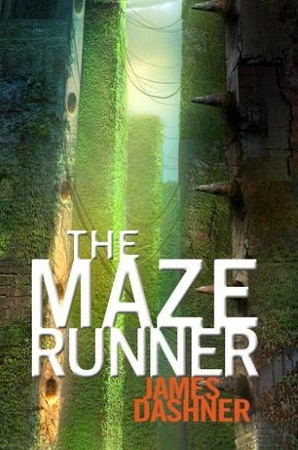

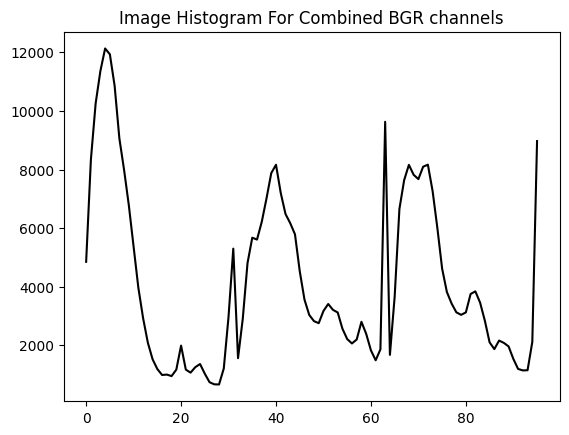

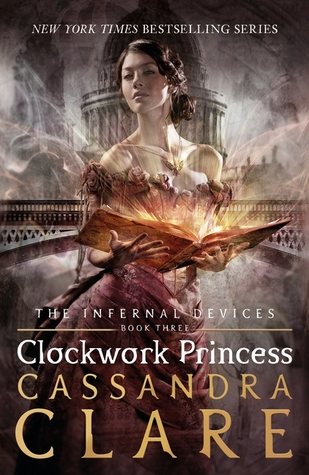

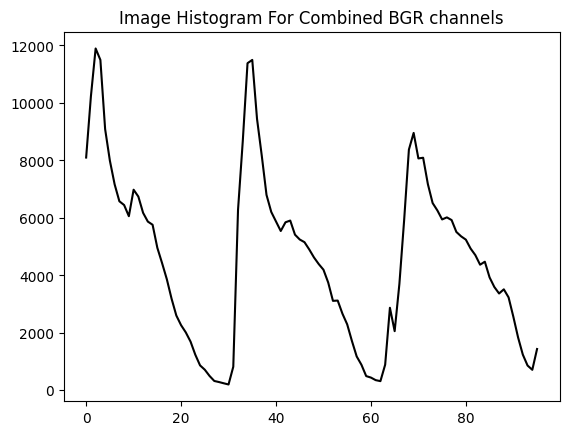

In [ ]:
print("The closest 4 images to the one above, using euclidean distance are:")
closest_histograms = euclidean_nearest(im_hist, histogram_df['Histogram'])

for hist in closest_histograms:
  # Find image.
  for i in range(0, len(histogram_df['Histogram'])):
    if (hist == histogram_df.loc[i, 'Histogram']).all():
      key = histogram_df.loc[i, 'BookId']
      break

  img = cv2.imread(key)
  ShowImage(hist, img)

* And now for cosine similarity:

In [ ]:
# Return the closest 4 vectors by cosine similarity.
def cosine_nearest(target_vector, vectors_list):
    distances = []

    for vector in vectors_list:
        similarity = cosine_similarity(target_vector.reshape(1, -1), vector.reshape(1, -1))
        distance = similarity[0][0]
        distances.append(distance)

    distances = np.array(distances)
    closest_indices = distances.argsort()[:4]
    closest_vectors = [vectors_list[i] for i in closest_indices]

    return closest_vectors

The closest 4 images to the one above using cosine similarity are:


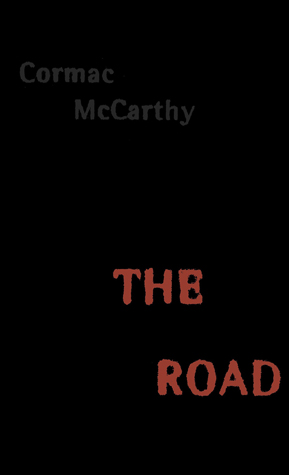

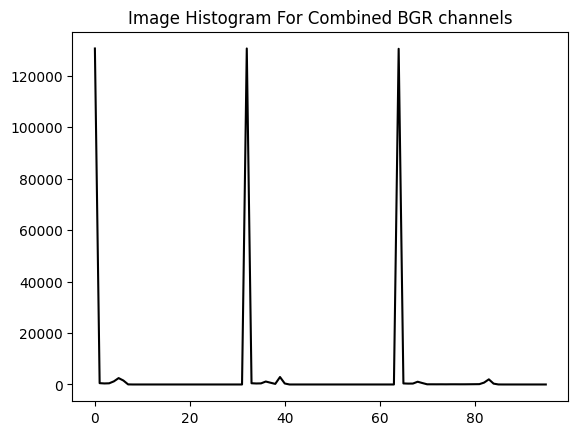

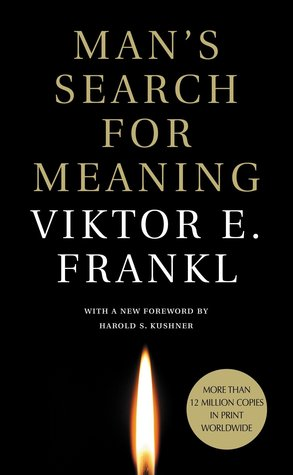

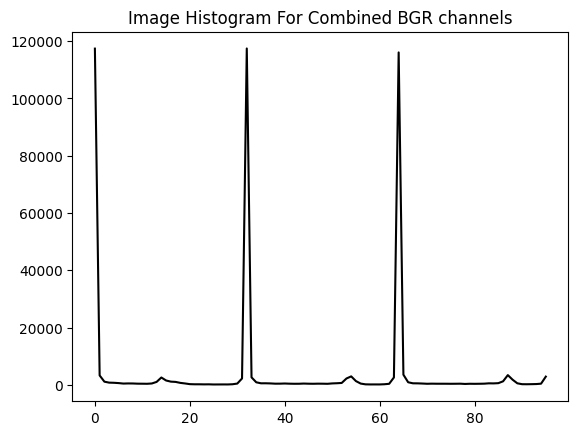

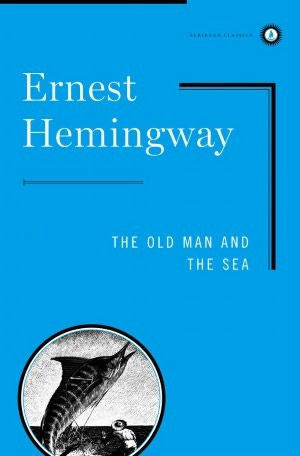

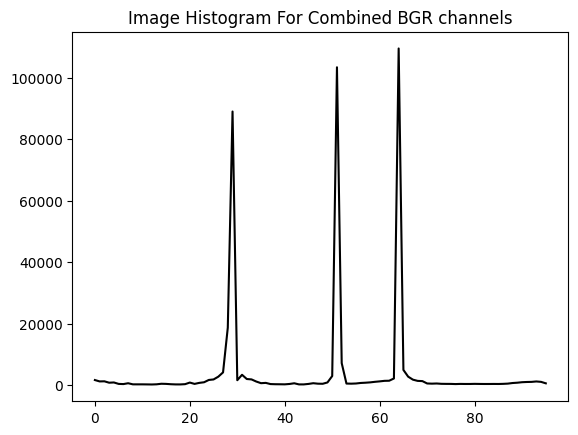

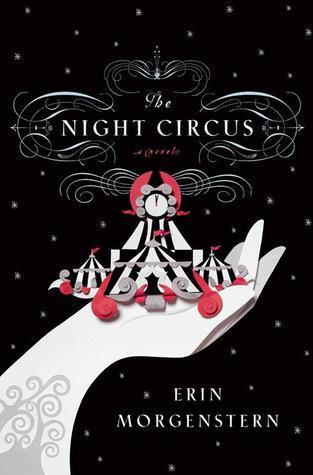

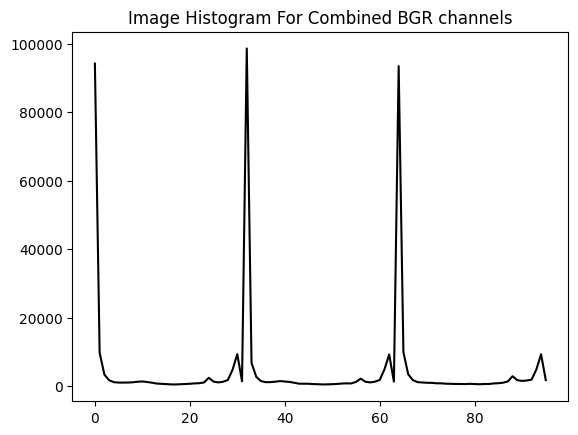

In [ ]:
print("The closest 4 images to the one above using cosine similarity are:")
closest_histograms = cosine_nearest(im_hist, histogram_df['Histogram'])

for hist in closest_histograms:
  # Find image.
  for i in range(0, len(histogram_df['Histogram'])):
    if (hist == histogram_df.loc[i, 'Histogram']).all():
      key = histogram_df.loc[i, 'BookId']
      break

  img = cv2.imread(key)
  ShowImage(hist, img)